In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
%matplotlib widget
import matplotlib.pyplot as plt

3d圖形範例 程式
確定有看到圖形之後就可以


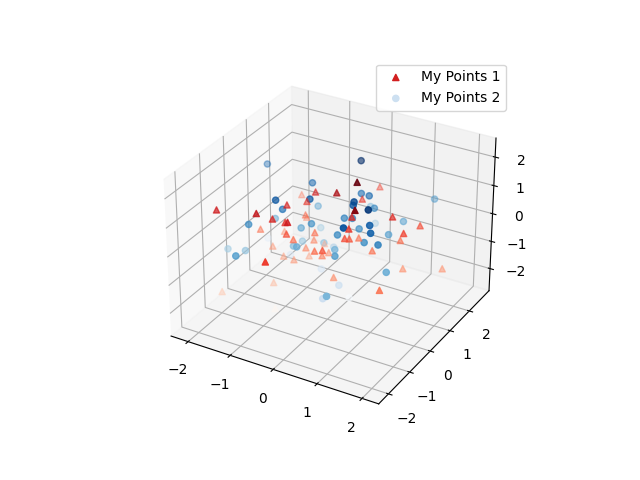

In [2]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 產生 3D 座標資料
z1 = np.random.randn(50)
x1 = np.random.randn(50)
y1 = np.random.randn(50)
z2 = np.random.randn(50)
x2 = np.random.randn(50)
y2 = np.random.randn(50)

# 繪製 3D 座標點
ax.scatter(x1, y1, z1, c=z1, cmap='Reds', marker='^', label='My Points 1')
ax.scatter(x2, y2, z2, c=z2, cmap='Blues', marker='o', label='My Points 2')

# 顯示圖例
ax.legend()

# 顯示圖形
plt.show()

In [3]:
#ICP Library functions code
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''
    #tolerance = 0.001
    #max_iterations=20
    #init_pose = None
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [4]:

A = np.random.randint(0,5,(10,3))    # 20 points for test

rotz = lambda theta: np.array([[np.cos(theta),-np.sin(theta),0],
                                    [np.sin(theta),np.cos(theta),0],
                                    [0,0,1]])
trans = np.array([2.12,-0.2,1.3])
B = A.dot(rotz(np.pi/4).T) + trans
#print(B)
T, distances,i = icp(A, B)

np.set_printoptions(precision=3,suppress=True)
print(T)

[[ 0.707 -0.707  0.     2.12 ]
 [ 0.707  0.707  0.    -0.2  ]
 [ 0.     0.     1.     1.3  ]
 [ 0.     0.     0.     1.   ]]


In [5]:
A_X= [i[0] for i in A]
#B_X =np.array([i[0] for i in B]).T
B_X =[i[0] for i in B]
A_Y = [i[1] for i in A]
#B_Y = np.array([i[1] for i in B]).T
B_Y = [i[1] for i in B]
A_Z = [i[2] for i in A]
#B_Z = np.array([i[2] for i in B]).T
B_Z = [i[2] for i in B]
#B_Y = np.array(B_Y)
#B_Y = B_Y.T
B_Y

[1.9213203435596429,
 1.2142135623730952,
 1.2142135623730952,
 2.62842712474619,
 1.9213203435596429,
 4.0426406871192855,
 2.62842712474619,
 2.62842712474619,
 1.2142135623730952,
 -0.2]

In [6]:
A

array([[0, 3, 3],
       [1, 1, 4],
       [2, 0, 1],
       [0, 4, 2],
       [2, 1, 0],
       [2, 4, 3],
       [2, 2, 1],
       [0, 4, 3],
       [2, 0, 1],
       [0, 0, 3]])

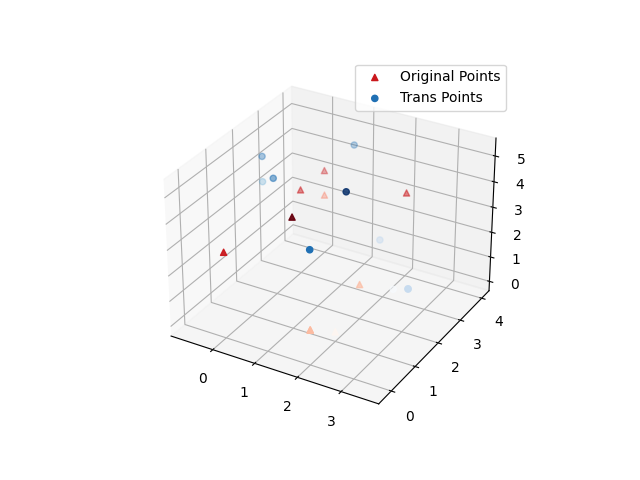

In [7]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(A_X, A_Y, A_Z, c=A_Z, cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X, B_Y, B_Z, c=B_Z, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
plt.show()

In [8]:
T

array([[ 0.707, -0.707,  0.   ,  2.12 ],
       [ 0.707,  0.707,  0.   , -0.2  ],
       [ 0.   ,  0.   ,  1.   ,  1.3  ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

Text(0.5, 0.92, 'Example of a uniformly sampled sphere')

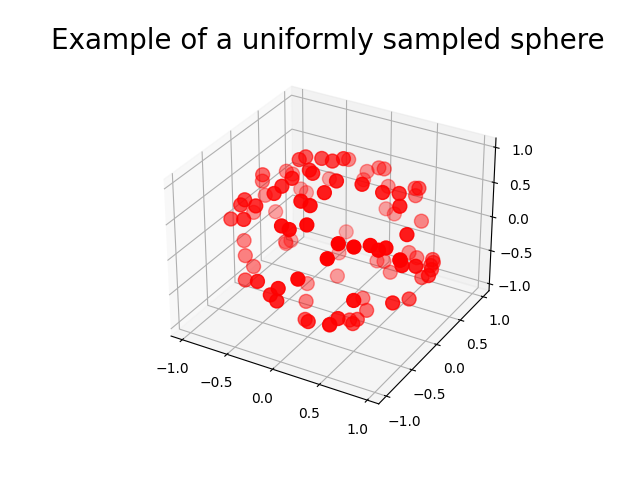

In [9]:
x = []
y = []
z = []
for i in range(100):
    u = np.random.normal(0,1)
    v = np.random.normal(0,1)
    w = np.random.normal(0,1)
    norm = (u*u + v*v + w*w)**(0.5)
    xi,yi,zi = u/norm,v/norm,w/norm
    x.append(xi)
    y.append(yi)
    z.append(zi)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(x, y, z, s=100, c='r', zorder=10)
ax.set_title('Example of a uniformly sampled sphere', fontdict={'fontsize':20})

In [13]:
A = []
for a,b,c in zip(x,y,z):
    A.append([a,b,c])

A = np.array(A)

B = A.dot(rotz(np.pi/4).T) #+ trans

In [14]:
A_X= [i[0] for i in A]
#B_X =np.array([i[0] for i in B]).T
B_X =[i[0] for i in B]
A_Y = [i[1] for i in A]
#B_Y = np.array([i[1] for i in B]).T
B_Y = [i[1] for i in B]
A_Z = [i[2] for i in A]
#B_Z = np.array([i[2] for i in B]).T
B_Z = [i[2] for i in B]
#B_Y = np.array(B_Y)
#B_Y = B_Y.T
B_Y

[0.856718197027874,
 -0.6199117385302565,
 0.7352385375628745,
 -0.22202011070493438,
 0.34110399376862044,
 0.027945092317118052,
 -0.20897798116508784,
 -0.4283200868784796,
 0.3624006218196653,
 0.15027804772413628,
 0.03895530529510263,
 0.2962252253671643,
 -0.5906804944574083,
 -0.5364436446561492,
 -0.5600328677418502,
 0.496193539449757,
 -0.17705454058190298,
 0.18960022802418286,
 -0.2971639352849564,
 -0.8634435901996327,
 0.2295489368212604,
 0.8625705867611496,
 -0.5665095808418394,
 0.5974116680817928,
 -0.23773218341249364,
 -0.6905244099896436,
 -0.23041877687537263,
 -0.18213244224147684,
 0.10851154128940495,
 0.49492119718142874,
 -0.27874755090416814,
 0.8018639311586949,
 0.5364574079705487,
 0.5498357332030778,
 0.9189512328135987,
 -0.24827688869960055,
 -0.49981398625041584,
 -0.45022066054435694,
 0.17865037425322214,
 0.2630474596218455,
 0.6224286697423338,
 -0.4137061518992174,
 -0.005870338499514118,
 -0.8478282957963738,
 -0.9207262995149407,
 0.3815590329

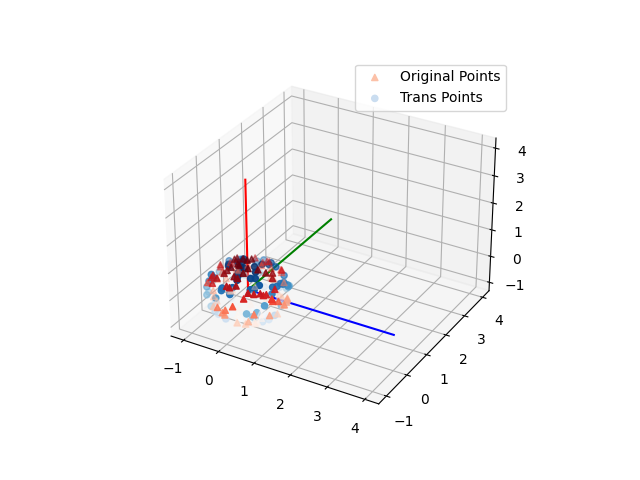

In [15]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(A_X, A_Y, A_Z, c=A_Z, cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X, B_Y, B_Z, c=B_Z, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
# some settings
vleng = 4
aleng = vleng/3.
p = np.array([vleng, 0, 0])
q = np.array([0, vleng, 0])
r = np.array([0, 0, vleng])
ax.plot(*np.vstack([[0,0,0], p]).T, color='b')
ax.plot(*np.vstack([[0,0,0], q]).T, color='g')
ax.plot(*np.vstack([[0,0,0], r]).T, color='r')
plt.show()

In [57]:
# 開始建立 旋轉座標公式
import math

#x0,y0,z0 為繞軸上一點 nx , ny, nz 為方向餘弦 theta為繞軸角度
def rotate_coordinate(x,y,z,theta,nx,ny,nz,x0,y0,z0):
    x_pulan = ((x-x0)*((nx*nx*(1-math.cos(theta)))+math.cos(theta)))+\
        ((y-y0)*((nx*ny*(1-math.cos(theta)))-(nz*math.sin(theta))))+\
            ((z-z0)*(nx*nz*((1-math.cos(theta))))+ny*math.sin(theta))+\
            x0
    y_pulan = (x-x0)*((nx*ny*(1-math.cos(theta)))+(nz*math.cos(theta)))+\
        (y-y0)*((ny*ny*(1-math.cos(theta)))-math.cos(theta))+\
            ((z-z0)*(ny*nz*((1-math.cos(theta))))-(nx*math.sin(theta)))+\
            y0
    z_pulan = (x-x0)*((nx*nz*(1-math.cos(theta)))-(ny*math.cos(theta)))+\
        (y-y0)*((ny*nz*(1-math.cos(theta)))-(nx*math.cos(theta)))+\
            (((z-z0)*(nz*nz*((1-math.cos(theta)))))-math.cos(theta))+\
            z0
    return x_pulan,y_pulan,z_pulan

#簡單驗證一下 繞z軸 逆時針旋轉90度的情形
x_r, y_r, z_r = rotate_coordinate(1,2,0,math.pi/2,0,0,1,0,0,2)
print(x_r,y_r,z_r)
# 如果用(1,2,0)當作原點時 繞z軸旋轉90度 應該會有y的數值 但目前算出來不是這樣 ?? 這邊y算出來幾乎是0?? why ?    


-2.0 -6.123233995736766e-17 2.220446049250313e-16


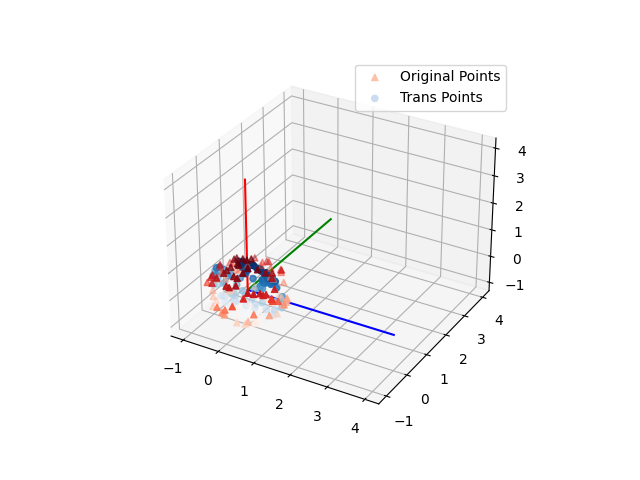

In [24]:
B_X_R=[]
B_Y_R=[]
B_Z_R=[]
for x,y,z in zip(A_X,A_Y,A_Z):
    x_r, y_r, z_r = rotate_coordinate(x,y,z,math.pi/2,0,0,1,0,0,0)
    B_X_R.append(x_r)
    B_Y_R.append(y_r)
    B_Z_R.append(z_r)

# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(A_X, A_Y, A_Z, c=A_Z, cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X_R, B_Y_R, B_Z_R, c=B_Z_R, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
# some settings
vleng = 4
aleng = vleng/3.
p = np.array([vleng, 0, 0])
q = np.array([0, vleng, 0])
r = np.array([0, 0, vleng])
ax.plot(*np.vstack([[0,0,0], p]).T, color='b')
ax.plot(*np.vstack([[0,0,0], q]).T, color='g')
ax.plot(*np.vstack([[0,0,0], r]).T, color='r')
plt.show()

In [28]:
import pandas as pd

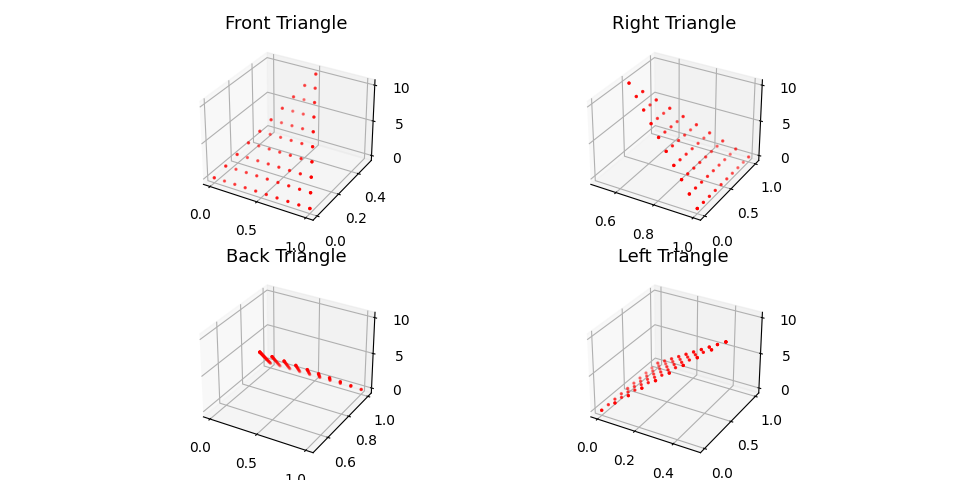

In [32]:
def get_random_cube_info():
    zero_ten = np.linspace(1,10,1000)
    x_1,x_2= np.random.choice(zero_ten,2)
    list_x = np.array([x_1,x_2])
    x_min = list_x.min()
    x_max = list_x.max()
    y_1,y_2= np.random.choice(zero_ten,2)
    list_y = np.array([y_1,y_2])
    y_min = list_y.min()
    y_max = list_y.max()
    z_1,z_2= np.random.choice(zero_ten,2)
    list_z = np.array([z_1,z_2])
    z_min = list_z.min()
    z_max = list_z.max()
    while True:
        if z_min==z_max:
            z_1,z_2= np.random.choice(zero_ten,2)
            list_z = np.array([z_1,z_2])
            z_min = list_z.min()
            z_max = list_z.max()
        if x_min==x_max:
            x_1,x_2= np.random.choice(zero_ten,2)
            list_x = np.array([x_1,x_2])
            x_min = list_x.min()
            x_max = list_x.max()
        if y_min==y_max:
            y_1,y_2= np.random.choice(zero_ten,2)
            list_y = np.array([y_1,y_2])
            y_min = list_y.min()
            y_max = list_y.max()
        else:
            break
    return [x_min,x_max,y_min,y_max,z_min,z_max]

def get_cube(x_min,x_max,y_min,y_max,z_min,z_max):
    


    x = np.linspace(x_min,x_max,13)
    y = np.linspace(y_min,y_max,13)
    z = np.linspace(z_min,z_max,13)
    # using list comprehension 
    # to compute all possible permutations
    res = [[i, j, k] for i in x 
                     for j in y
                     for k in z]
    res = np.array(res)
    res = res.reshape(-1,3)
    res = pd.DataFrame(res)
    res = res.sample(frac=1)
    res = res[0:2000]
    return res

def sphere(u_sample,v_sample,w_sample,norm_mult):
    x = []
    y = []
    z = []
    for i in range(700):
        u = np.random.normal(0,u_sample)
        v = np.random.normal(0,v_sample)
        w = np.random.normal(0,w_sample)
        norm = (u*u + v*v + w*w)**(0.5)
        xi,yi,zi = u/norm*norm_mult,v/norm*norm_mult,w/norm*norm_mult
        x.append(xi)
        y.append(yi)
        z.append(zi)
    return [x,y,z]
def get_random_sphere_info():
    zero_ten = np.linspace(1,10,100)
    u,v,w,mult = np.random.choice(zero_ten,4)
    return [u,v,w,mult]
def get_random_sphere():
    u,w,w,mult = get_random_sphere_info()
    s = sphere(u,v,w,mult)
    return s 

def get_square(y_min,y_max,x_min,x_max,z_v):
    x = np.linspace(x_min,x_max,50)
    y = np.linspace(y_min,y_max,50)
    z = [z_v]*len(x)
    square = []
    for xi in x:
        for yi in y:
            square.append([xi,yi,z_v])
    square = np.array(square)
    square = square.reshape(-1,3)
    square = pd.DataFrame(square,columns=['x','y','z'])
    square = square.round(2)
    return square

def get_vert(h,square):
    z = square['z'].drop_duplicates().to_list()[0]
    h = z + h
    x_mean = square['x'].mean()
    y_mean = square['y'].mean()
    square = square.append({'x':x_mean,'y':y_mean,'z':h},ignore_index=True)
    return square

def get_square_vert(y_min,y_max,x_min,x_max,z_v,h):
    square = get_square(y_min,y_max,x_min,x_max,z_v)
    square_and_vert = get_vert(h,square=square)
    return square_and_vert

def line(x_a,x_b,y_a,y_b,z_a,z_b):
    t = np.linspace(0,1,10)
    z_delta = z_b-z_a
    x_delta = x_b-x_a
    y_delta = y_b-y_a
    x = []
    y = []
    z  = []
    for ti in t:
        xi = x_a + x_delta * ti
        yi = y_a + y_delta * ti
        zi = z_a + z_delta * ti
        x.append(xi)
        y.append(yi)
        z.append(zi)
    line_data = pd.DataFrame({'x':x,'y':y,'z':z})
    return line_data
def add_first_lines(y_min,y_max,x_min,x_max,z_v,h):
    square = get_square(y_min,y_max,x_min,x_max,z_v)
    square_and_vert = get_vert(h,square=square)
    x_1 = square['x'].min()
    x_2 = square['x'].mean()
    y_1 = square['y'].min()
    y_2 = square['y'].mean()
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    first_line = line(x_1,x_2,y_1,y_2,z_1,z_2)
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    x_1 = square['x'].max()
    x_2 = square['x'].mean()
    y_1 = square['y'].min()
    y_2 = square['y'].mean()
    second_line = line(x_a=x_1,x_b=x_2,y_a=y_1,y_b=y_2,z_a=0,z_b=10)
    result = first_line.append(second_line)
    order_results = result.sort_values(by='z',ascending = False).reset_index().drop('index',axis=1)
    z_values = order_results.z.drop_duplicates().to_list()
    number_of_values =np.linspace(1,max(z_values),len(z_values)).astype(int)
    x = []
    y = []
    z = []
    for i in range(len(z_values)):
        zi = z_values[i]
        ni = number_of_values[i]
        y_value = np.array(order_results[order_results.z==zi].y)
        y_value = np.linspace(y_value.min(),y_value.max(),ni)
        x_value = np.array(order_results[order_results.z==zi].x)
        x_value = np.linspace(x_value.min(),x_value.max(),ni)
        for n in range(ni):
            z.append(zi)
            y.append(y_value[n])
            x.append(x_value[n])
    to_add = pd.DataFrame({'x':x,'y':y,'z':z})
    result = result.append(to_add)
    return result
def add_second_lines(y_min,y_max,x_min,x_max,z_v,h):
    square = get_square(y_min,y_max,x_min,x_max,z_v)
    square_and_vert = get_vert(h,square=square)
    x_1 = square['x'].max()
    x_2 = square['x'].mean()
    y_1 = square['y'].min()
    y_2 = square['y'].mean()
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    first_line = line(x_1,x_2,y_1,y_2,z_1,z_2)
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    x_1 = square['x'].max()
    x_2 = square['x'].mean()
    y_1 = square['y'].max()
    y_2 = square['y'].mean()
    second_line = line(x_a=x_1,x_b=x_2,y_a=y_1,y_b=y_2,z_a=0,z_b=10)
    result = first_line.append(second_line)
    order_results = result.sort_values(by='z',ascending = False).reset_index().drop('index',axis=1)
    z_values = order_results.z.drop_duplicates().to_list()
    number_of_values =np.linspace(1,max(z_values),len(z_values)).astype(int)
    x = []
    y = []
    z = []
    for i in range(len(z_values)):
        zi = z_values[i]
        ni = number_of_values[i]
        y_value = np.array(order_results[order_results.z==zi].y)
        y_value = np.linspace(y_value.min(),y_value.max(),ni)
        x_value = np.array(order_results[order_results.z==zi].x)
        x_value = np.linspace(x_value.min(),x_value.max(),ni)
        for n in range(ni):
            z.append(zi)
            y.append(y_value[n])
            x.append(x_value[n])
    to_add = pd.DataFrame({'x':x,'y':y,'z':z})
    result = result.append(to_add)
    return result

def add_third_lines(y_min,y_max,x_min,x_max,z_v,h):
    square = get_square(y_min,y_max,x_min,x_max,z_v)
    square_and_vert = get_vert(h,square=square)
    x_1 = square['x'].max()
    x_2 = square['x'].mean()
    y_1 = square['y'].max()
    y_2 = square['y'].mean()
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    first_line = line(x_1,x_2,y_1,y_2,z_1,z_2)
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    x_1 = square['x'].min()
    x_2 = square['x'].mean()
    y_1 = square['y'].max()
    y_2 = square['y'].mean()
    second_line = line(x_a=x_1,x_b=x_2,y_a=y_1,y_b=y_2,z_a=0,z_b=10)
    result = first_line.append(second_line)
    order_results = result.sort_values(by='z',ascending = False).reset_index().drop('index',axis=1)
    z_values = order_results.z.drop_duplicates().to_list()
    number_of_values =np.linspace(1,max(z_values),len(z_values)).astype(int)
    x = []
    y = []
    z = []
    for i in range(len(z_values)):
        zi = z_values[i]
        ni = number_of_values[i]
        y_value = np.array(order_results[order_results.z==zi].y)
        y_value = np.linspace(y_value.min(),y_value.max(),ni)
        x_value = np.array(order_results[order_results.z==zi].x)
        x_value = np.linspace(x_value.min(),x_value.max(),ni)
        for n in range(ni):
            z.append(zi)
            y.append(y_value[n])
            x.append(x_value[n])
    to_add = pd.DataFrame({'x':x,'y':y,'z':z})
    result = result.append(to_add)
    return result

def add_fourth_lines(y_min,y_max,x_min,x_max,z_v,h):
    square = get_square(y_min,y_max,x_min,x_max,z_v)
    square_and_vert = get_vert(h,square=square)
    x_1 = square['x'].min()
    x_2 = square['x'].mean()
    y_1 = square['y'].min()
    y_2 = square['y'].mean()
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    first_line = line(x_1,x_2,y_1,y_2,z_1,z_2)
    z_1 = square_and_vert['z'].min()
    z_2 = square_and_vert['z'].max()
    x_1 = square['x'].min()
    x_2 = square['x'].mean()
    y_1 = square['y'].max()
    y_2 = square['y'].mean()
    second_line = line(x_a=x_1,x_b=x_2,y_a=y_1,y_b=y_2,z_a=0,z_b=10)
    result = first_line.append(second_line)
    order_results = result.sort_values(by='z',ascending = False).reset_index().drop('index',axis=1)
    z_values = order_results.z.drop_duplicates().to_list()
    number_of_values =np.linspace(1,max(z_values),len(z_values)).astype(int)
    x = []
    y = []
    z = []
    for i in range(len(z_values)):
        zi = z_values[i]
        ni = number_of_values[i]
        y_value = np.array(order_results[order_results.z==zi].y)
        y_value = np.linspace(y_value.min(),y_value.max(),ni)
        x_value = np.array(order_results[order_results.z==zi].x)
        x_value = np.linspace(x_value.min(),x_value.max(),ni)
        for n in range(ni):
            z.append(zi)
            y.append(y_value[n])
            x.append(x_value[n])
    to_add = pd.DataFrame({'x':x,'y':y,'z':z})
    result = result.append(to_add)
    return result

first = add_first_lines(0,1,0,1,0,10)
second = add_second_lines(0,1,0,1,0,10)
third = add_third_lines(0,1,0,1,0,10)
fourth = add_fourth_lines(0,1,0,1,0,10)
tot = [first,second,third,fourth]
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))
strings = ['Front ','Right ','Back ','Left ']

for i in range(1,5):
#===============
#  First subplot
#===============
    # set up the axes for the first plot
    ax = fig.add_subplot(2, 2, i, projection='3d')
    x_min,x_max,y_min,y_max,z_min,z_max=get_random_cube_info()
    
    ax.set_title(strings[i-1]+'Triangle',
                 fontdict = {'fontsize': 13,
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'})
    cube= tot[i-1]
    x = cube['x']
    y = cube['y']
    z= cube['z']
    #ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
    ax.scatter(x, y, z, s=2, c='r', zorder=10)

    #===============
    # Second subplot
    #===============
    # set up the axes for the second plot
plt.tight_layout()

In [34]:
def create_pyramid(y_min,y_max,x_min,x_max,z_v,h,standardize = False):
    first = add_first_lines(y_min,y_max,x_min,x_max,z_v,h)
    second =  add_second_lines(y_min,y_max,x_min,x_max,z_v,h)
    third =  add_third_lines(y_min,y_max,x_min,x_max,z_v,h)
    fourth =  add_fourth_lines(y_min,y_max,x_min,x_max,z_v,h)
    triangles = first.append(second).append(third).append(fourth)
    square = get_square(y_min,y_max,x_min,x_max,z_v)
    pyramid = square.append(triangles)
    pyramid = pyramid.sample(frac=1)
    if standardize == True:
        pyramid = pyramid[0:2000]
    return pyramid

In [35]:
st_pyramid = create_pyramid(0,1,0,1,0,10,standardize = True)
non_st_pyramid = create_pyramid(0,1,0,1,0,10,standardize = False)

Text(0.5, 0.92, 'Example of a standardized pyramid')

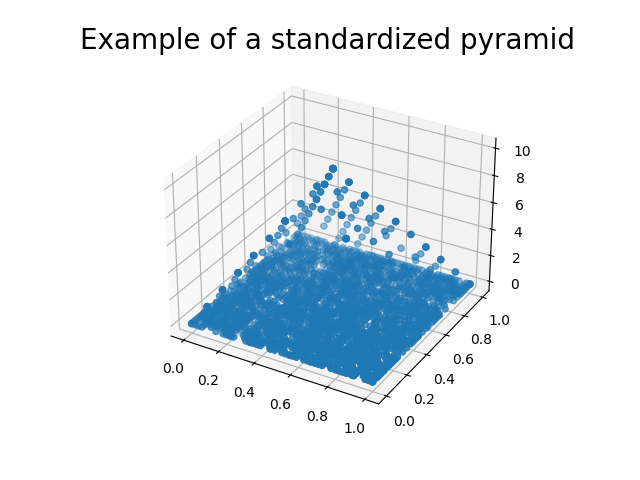

In [36]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(st_pyramid['x'], st_pyramid['y'], st_pyramid['z'])
ax.set_title('Example of a standardized pyramid', fontdict={'fontsize':20})

In [38]:
st_pyramid

,x,y,z
1861,0.760000,0.22,0.000000
272,0.100000,0.45,0.000000
2482,1.000000,0.65,0.000000
1226,0.490000,0.53,0.000000
2391,0.960000,0.84,0.000000
...,...,...,...
2048,0.820000,0.98,0.000000
232,0.080000,0.65,0.000000
306,0.120000,0.12,0.000000
367,0.140000,0.35,0.000000


C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


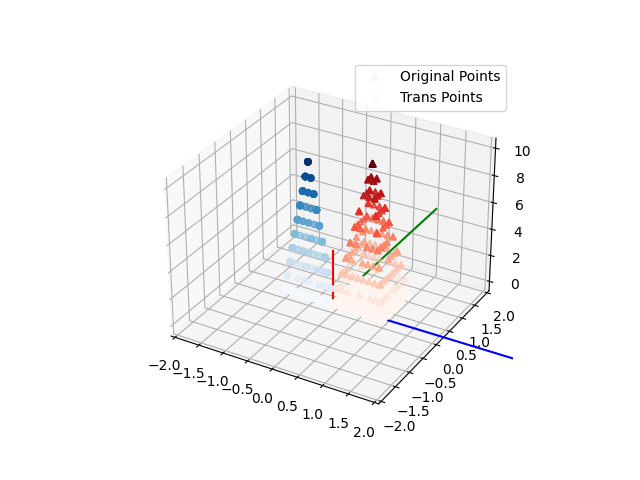

In [51]:
B_X_R=[]
B_Y_R=[]
B_Z_R=[]
for x,y,z in zip(st_pyramid['x'],st_pyramid['y'],st_pyramid['z']):
    x_r, y_r, z_r = rotate_coordinate(x,y,z,math.pi/2,0,0,1,0,0,0)
    B_X_R.append(x_r)
    B_Y_R.append(y_r)
    B_Z_R.append(z_r)

# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(st_pyramid['x'], st_pyramid['y'], st_pyramid['z'], c=st_pyramid['z'], cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X_R, B_Y_R, B_Z_R, c=B_Z_R, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
# some settings
vleng = 4
aleng = vleng/3.
p = np.array([vleng, 0, 0])
q = np.array([0, vleng, 0])
r = np.array([0, 0, vleng])
ax.plot(*np.vstack([[0,0,0], p]).T, color='b')
ax.set_xlim(-2,2)
ax.plot(*np.vstack([[0,0,0], q]).T, color='g')
ax.set_ylim(-2,2)
ax.plot(*np.vstack([[0,0,0], r]).T, color='r')
plt.show()

In [46]:
len(st_pyramid['x'])

2000

In [47]:
len(B_Z_R)

2000

In [65]:
import numpy as np
import math
import scipy.linalg as linalg
import matplotlib as mpl 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 

#旋转矩阵 欧拉角
def rotate_mat(axis, radian):
    rot_matrix = linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * radian))
    return rot_matrix
# 分别是x,y和z轴,也可以自定义旋转轴
axis_x, axis_y, axis_z = [1,0,0], [0,1,0], [0, 0, 1]
rand_axis = [0,0,1]
#旋转角度
yaw = math.pi/2 #90度逆時針
#返回旋转矩阵
rot_matrix = rotate_mat(rand_axis, yaw)
#print(rot_matrix)
# 计算点绕着轴运动后的点
x = [1,2,0]
x1 = np.dot(rot_matrix,x)
# 旋转后的坐标
print(x1)   
# 计算各轴偏移量
#print([x1[i]-x[i] for i in range(3)])


[-2.  1.  0.]


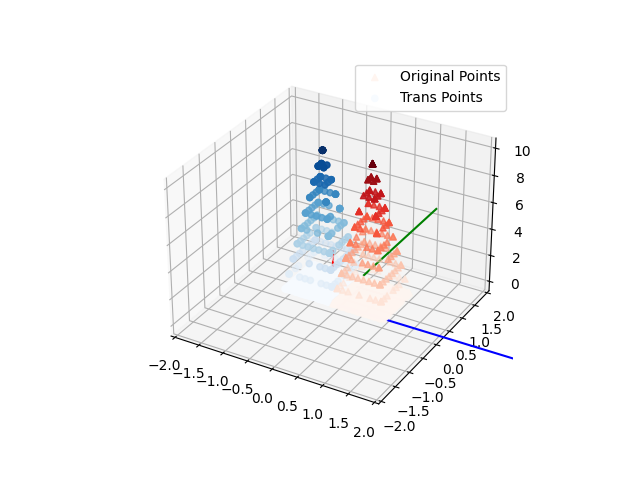

In [68]:
B_X_R=[]
B_Y_R=[]
B_Z_R=[]
for x,y,z in zip(st_pyramid['x'],st_pyramid['y'],st_pyramid['z']):
    position = [x,y,z]
    x_r, y_r, z_r = np.dot(rot_matrix,position)
    B_X_R.append(x_r)
    B_Y_R.append(y_r)
    B_Z_R.append(z_r)

# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(st_pyramid['x'], st_pyramid['y'], st_pyramid['z'], c=st_pyramid['z'], cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X_R, B_Y_R, B_Z_R, c=B_Z_R, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
# some settings
vleng = 4
aleng = vleng/3.
p = np.array([vleng, 0, 0])
q = np.array([0, vleng, 0])
r = np.array([0, 0, vleng])
ax.plot(*np.vstack([[0,0,0], p]).T, color='b')
ax.set_xlim(-2,2)
ax.plot(*np.vstack([[0,0,0], q]).T, color='g')
ax.set_ylim(-2,2)
ax.plot(*np.vstack([[0,0,0], r]).T, color='r')
plt.show()